In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime
from scipy.spatial.distance import mahalanobis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn import tree, ensemble, neighbors, naive_bayes, decomposition, linear_model
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.optimizers import Adam

In [3]:
import os
os.environ['PROJ_LIB'] = r'C:\ProgramData\Anaconda3\pkgs\proj4-5.2.0-hfa6e2cd_1001\Library\share'

In [4]:
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [12]:
#cityData = pd.read_csv('dataset_TSMC2014_NYC.csv')
cityData = pd.read_csv('dataset_TSMC2014_TKY.csv',encoding= 'latin-1')

print("Number of Check-In Records: ", cityData.shape[0])
print("Number of Unique Checkin Venues: ", len(np.unique(cityData.venueId)))
print("Number of Unique Venue Categories: ", len(np.unique(cityData.venueCategory)))
print("Number of Unique User IDs: ", len(np.unique(cityData.userId)))

Number of Check-In Records:  573703
Number of Unique Checkin Venues:  61858
Number of Unique Venue Categories:  247
Number of Unique User IDs:  2293


In [13]:
cityData.head()

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp
0,1541,4f0fd5a8e4b03856eeb6c8cb,4bf58dd8d48988d10c951735,Cosmetics Shop,35.705101,139.619590,540,Tue Apr 03 18:17:18 +0000 2012
1,868,4b7b884ff964a5207d662fe3,4bf58dd8d48988d1d1941735,Ramen / Noodle House,35.715581,139.800317,540,Tue Apr 03 18:22:04 +0000 2012
2,114,4c16fdda96040f477cc473a5,4d954b0ea243a5684a65b473,Convenience Store,35.714542,139.480065,540,Tue Apr 03 19:12:07 +0000 2012
3,868,4c178638c2dfc928651ea869,4bf58dd8d48988d118951735,Food & Drink Shop,35.725592,139.776633,540,Tue Apr 03 19:12:13 +0000 2012
4,1458,4f568309e4b071452e447afe,4f2a210c4b9023bd5841ed28,Housing Development,35.656083,139.734046,540,Tue Apr 03 19:18:23 +0000 2012


In [14]:
cityData['localTime'] = pd.to_datetime(cityData.utcTimestamp) + pd.to_timedelta(cityData.timezoneOffset, unit = 'm')

In [15]:
cityData.head()

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,localTime
0,1541,4f0fd5a8e4b03856eeb6c8cb,4bf58dd8d48988d10c951735,Cosmetics Shop,35.705101,139.619590,540,Tue Apr 03 18:17:18 +0000 2012,2012-04-04 03:17:18+00:00
1,868,4b7b884ff964a5207d662fe3,4bf58dd8d48988d1d1941735,Ramen / Noodle House,35.715581,139.800317,540,Tue Apr 03 18:22:04 +0000 2012,2012-04-04 03:22:04+00:00
2,114,4c16fdda96040f477cc473a5,4d954b0ea243a5684a65b473,Convenience Store,35.714542,139.480065,540,Tue Apr 03 19:12:07 +0000 2012,2012-04-04 04:12:07+00:00
3,868,4c178638c2dfc928651ea869,4bf58dd8d48988d118951735,Food & Drink Shop,35.725592,139.776633,540,Tue Apr 03 19:12:13 +0000 2012,2012-04-04 04:12:13+00:00
4,1458,4f568309e4b071452e447afe,4f2a210c4b9023bd5841ed28,Housing Development,35.656083,139.734046,540,Tue Apr 03 19:18:23 +0000 2012,2012-04-04 04:18:23+00:00


In [16]:
# Day of week, 0 = Monday, 6 = Sunday
cityData['localDayofWeek'] = cityData.localTime.dt.dayofweek
# Use only Hour component
cityData['localHour'] = cityData.localTime.dt.hour

In [17]:
cityData

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,localTime,localDayofWeek,localHour
0,1541,4f0fd5a8e4b03856eeb6c8cb,4bf58dd8d48988d10c951735,Cosmetics Shop,35.705101,139.619590,540,Tue Apr 03 18:17:18 +0000 2012,2012-04-04 03:17:18+00:00,2,3
1,868,4b7b884ff964a5207d662fe3,4bf58dd8d48988d1d1941735,Ramen / Noodle House,35.715581,139.800317,540,Tue Apr 03 18:22:04 +0000 2012,2012-04-04 03:22:04+00:00,2,3
2,114,4c16fdda96040f477cc473a5,4d954b0ea243a5684a65b473,Convenience Store,35.714542,139.480065,540,Tue Apr 03 19:12:07 +0000 2012,2012-04-04 04:12:07+00:00,2,4
3,868,4c178638c2dfc928651ea869,4bf58dd8d48988d118951735,Food & Drink Shop,35.725592,139.776633,540,Tue Apr 03 19:12:13 +0000 2012,2012-04-04 04:12:13+00:00,2,4
4,1458,4f568309e4b071452e447afe,4f2a210c4b9023bd5841ed28,Housing Development,35.656083,139.734046,540,Tue Apr 03 19:18:23 +0000 2012,2012-04-04 04:18:23+00:00,2,4
...,...,...,...,...,...,...,...,...,...,...,...
573698,326,4bab3456f964a5204d993ae3,4bf58dd8d48988d1e9931735,Music Venue,35.656939,139.702518,540,Sat Feb 16 02:34:35 +0000 2013,2013-02-16 11:34:35+00:00,5,11
573699,853,4b559c09f964a520efe827e3,4bf58dd8d48988d129951735,Train Station,35.858740,139.657286,540,Sat Feb 16 02:34:53 +0000 2013,2013-02-16 11:34:53+00:00,5,11
573700,1502,5101e81ee4b020384100b0a5,4bf58dd8d48988d1dc931735,Tea Room,35.701748,139.771216,540,Sat Feb 16 02:34:55 +0000 2013,2013-02-16 11:34:55+00:00,5,11
573701,408,4bbc5648afe1b7134743304b,4bf58dd8d48988d16e941735,Fast Food Restaurant,35.670465,139.768348,540,Sat Feb 16 02:35:17 +0000 2013,2013-02-16 11:35:17+00:00,5,11


In [18]:
def convertCoord(lat, long):
    
    # Earth's radius = 6371 km
    R = 6371
    
    x = R * math.cos(math.radians(lat)) * math.cos(math.radians(long))
    y = R * math.cos(math.radians(lat)) * math.sin(math.radians(long))
    z = R * math.sin(math.radians(lat))
    
    return [x, y, z]

In [21]:
LocData = cityData.loc[:, ['userId', 'latitude', 'longitude']].values

convCoords = []

for i in range(LocData.shape[0]):    
    convCoords.append(convertCoord(LocData[i, 1], LocData[i, 2]))

convCoords = np.array(convCoords)

cityData['x'] = convCoords[:, 0]
cityData['y'] = convCoords[:, 1]
cityData['z'] = convCoords[:, 2]

cityMeanX, cityMeanY, cityMeanZ = cityData[['x', 'y', 'z']].mean()

In [22]:
LocData = cityData.loc[:, ['userId', 'latitude', 'longitude', 'x', 'y', 'z', 'localTime', 'venueCategory']].values

usrLastLat = []
usrLastLong = []
usrLastX = []
usrLastY = []
usrLastZ = []
usrLastTime = []
usrLastCat = []
usrMeanX = []
usrMeanY = []
usrMeanZ = []

for i in range(LocData.shape[0]):
    currUser = LocData[i, 0]
    histLoc = LocData[:i, :]
    histLoc = histLoc[histLoc[:, 0] == currUser, :]
    
    if histLoc.shape[0] == 0:
        usrLastLat.append(float('nan'))
        usrLastLong.append(float('nan'))
        usrLastX.append(float('nan'))
        usrLastY.append(float('nan'))
        usrLastZ.append(float('nan'))
        usrLastTime.append(pd.to_datetime('NaT'))
        usrLastCat.append('')
        usrMeanX.append(float('nan'))
        usrMeanY.append(float('nan'))
        usrMeanZ.append(float('nan'))
    else:
        usrLastLat.append(histLoc[-1, 1])
        usrLastLong.append(histLoc[-1, 2])
        usrLastX.append(histLoc[-1, 3])
        usrLastY.append(histLoc[-1, 4])
        usrLastZ.append(histLoc[-1, 5])
        usrLastTime.append(histLoc[-1, 6])
        usrLastCat.append(histLoc[-1, 7])
        usrMeanX.append(np.mean(histLoc[:, 3]))
        usrMeanY.append(np.mean(histLoc[:, 4]))
        usrMeanZ.append(np.mean(histLoc[:, 5]))
    
    if i % 100000 == 0:
        print("Processing Record ", i)

cityData['usrLastLat'] = usrLastLat
cityData['usrLastLong'] = usrLastLong
cityData['usrLastX'] = usrLastX
cityData['usrLastY'] = usrLastY
cityData['usrLastZ'] = usrLastZ
cityData['usrLastTime'] = usrLastTime
cityData['usrLastCat'] = usrLastCat
cityData['usrMeanX'] = usrMeanX
cityData['usrMeanY'] = usrMeanY
cityData['usrMeanZ'] = usrMeanZ



Processing Record  0
Processing Record  100000
Processing Record  200000
Processing Record  300000
Processing Record  400000
Processing Record  500000


AttributeError: 'DataFrame' object has no attribute 'as_matrix'

In [24]:
cityData['usrLastDist'] = np.linalg.norm(cityData.loc[:, ['x', 'y', 'z']].values - 
                                         cityData.loc[:, ['usrLastX', 'usrLastY', 'usrLastZ']].values, 
                                         axis = 1)
cityData['usrMeanDist'] = np.linalg.norm(cityData.loc[:, ['x', 'y', 'z']].values - 
                                         cityData.loc[:, ['usrMeanX', 'usrMeanY', 'usrMeanZ']].values, 
                                         axis = 1)
cityData['usrLastTimeDiff'] = pd.to_timedelta(cityData.loc[:, 'localTime'].values - 
                                              cityData.loc[:, 'usrLastTime'].values, 
                                              unit = 's').seconds

In [25]:
cityData.to_csv('dataset_TSMC2014_TKY_processed.csv', index = False, encoding='utf-8')

#cityData = pd.read_csv('foursquare-nyc-and-tokyo-check-ins\\dataset_TSMC2014_TKY_processed.csv')
#cityData.localTime = pd.to_datetime(cityData.localTime)


In [26]:
# Mapping between venue and category
venueCatMap = cityData.groupby(['venueId', 'venueCategory']).count()
venueCatMap.reset_index(inplace = True)
venueCatMap = venueCatMap.loc[:, ['venueId', 'venueCategory']]

# Remove duplicated venue ID: with more than 1 category
dropIdx = venueCatMap.duplicated('venueId')
venueCatMap = venueCatMap.loc[~dropIdx, :]
venueCatMap.set_index('venueId', inplace = True)

# 301 duplicated categories
print("Number of Duplicated Venue-Category Pairs Dropped: ", np.sum(dropIdx))

Number of Duplicated Venue-Category Pairs Dropped:  520


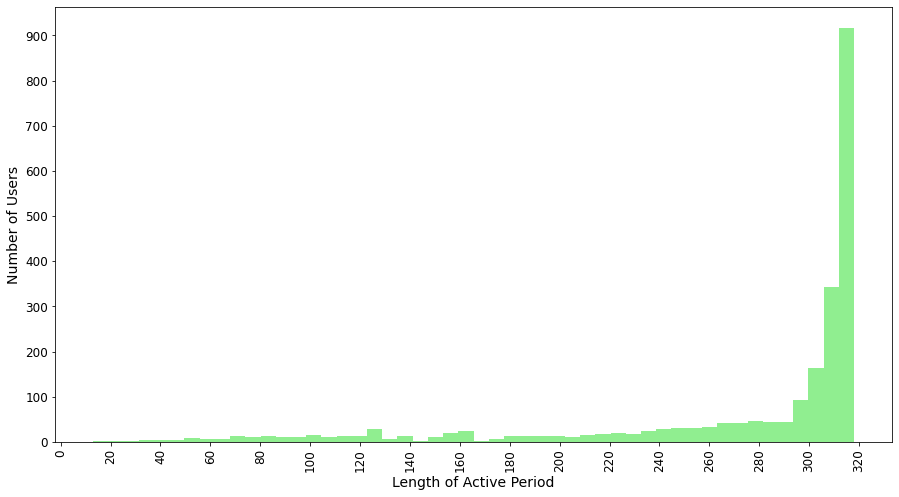

In [27]:
# x = localTime
def activePeriods(x):    
    numUsages = len(x)    
    if numUsages == 1:
        return pd.to_timedelta(0)
    else:
        return max(x) - min(x)

usrActPeriods = cityData.groupby(['userId'])['localTime'].agg(activePeriods)

# Most users consistently use it over long periods
plt.figure(figsize = (15, 8))
plt.hist(usrActPeriods.dt.days, bins = 50, color = "lightgreen")
plt.xticks(np.arange(0, 321, 20), rotation = 90, fontsize = 12)
plt.yticks(np.arange(0, 901, 100), fontsize = 12)
plt.xlabel("Length of Active Period", fontsize = 14)
plt.ylabel("Number of Users", fontsize = 14)
plt.show()
plt.close()

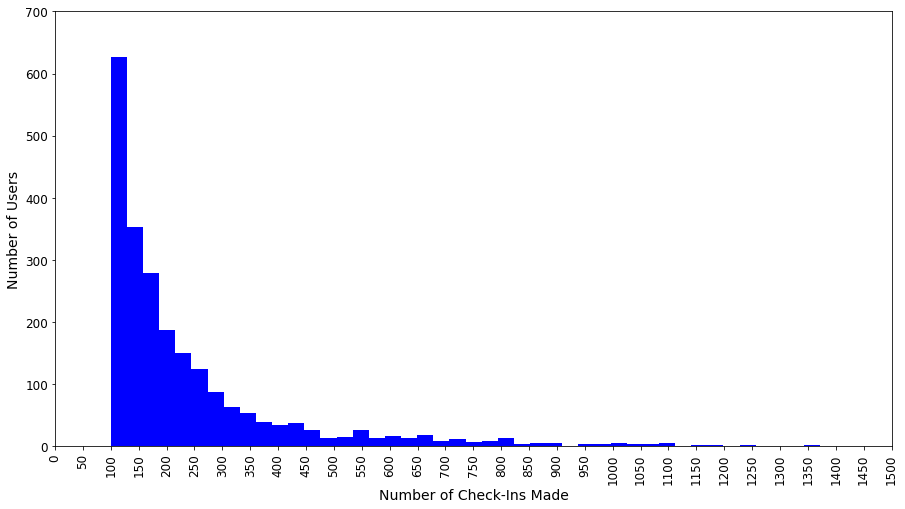

In [28]:
# Usage count of each user
plt.figure(figsize = (15, 8))
plt.hist(list(cityData.groupby('userId')['venueId'].count()), bins = 100, color = 'blue')
plt.xticks(np.arange(0, 3001, 50), rotation = 90, fontsize = 12)
plt.yticks(fontsize = 12)
plt.axis([0, 1501, 0, 700])
plt.xlabel("Number of Check-Ins Made", fontsize = 14)
plt.ylabel("Number of Users", fontsize = 14)
plt.show()
plt.close()


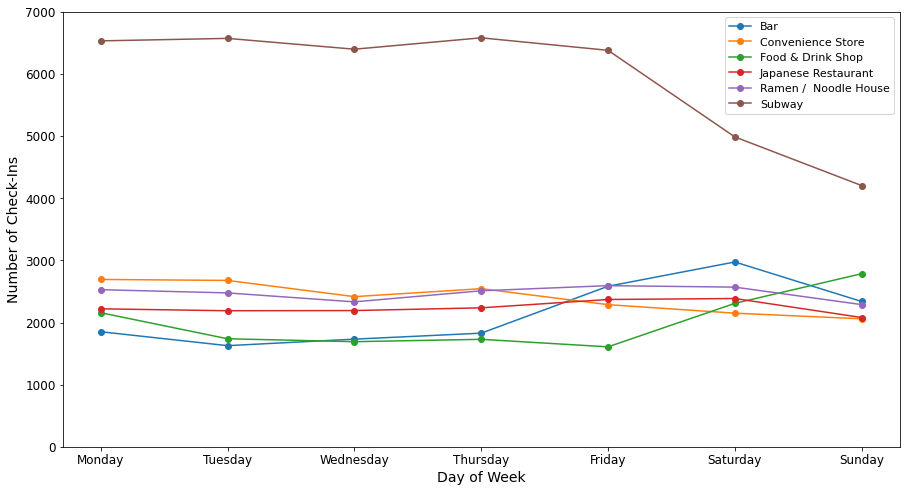

In [29]:
topSixCats = cityData.groupby(['venueCategory'])['venueId'].count().sort_values(ascending = False)[1:7] # Skip Train Station Category
topSixCats_ByDay = cityData.loc[cityData.venueCategory.isin(topSixCats.index.tolist()), :] \
                        .groupby(['venueCategory', 'localDayofWeek'])['localTime'].count()

plt.figure(figsize = (15, 8))

for cat in topSixCats_ByDay.index.levels[0].tolist():
    plt.plot(topSixCats_ByDay[cat].index.tolist(), topSixCats_ByDay[cat].values, marker = 'o', label = cat)

plt.xticks(np.arange(0, 7, 1), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'), fontsize = 12)
plt.yticks(np.arange(0, 7001, 1000), fontsize = 12)
plt.legend(loc = 'upper right', fontsize = 11)
plt.ylabel('Number of Check-Ins', fontsize = 14)
plt.xlabel('Day of Week', fontsize = 14)
plt.show()
plt.close()

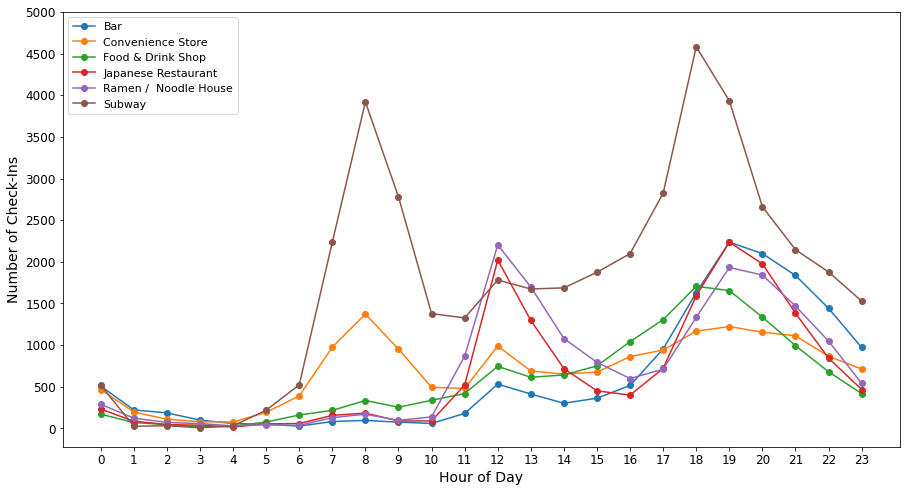

In [30]:
topSixCats_ByHour = cityData.loc[cityData.venueCategory.isin(topSixCats.index.tolist()), :] \
                        .groupby(['venueCategory', 'localHour'])['localTime'].count()

plt.figure(figsize = (15, 8))

for cat in topSixCats_ByHour.index.levels[0].tolist():
    plt.plot(topSixCats_ByHour[cat].index.tolist(), topSixCats_ByHour[cat].values, marker = 'o', label = cat)

plt.xticks(np.arange(0, 24, 1), fontsize = 12)
plt.yticks(np.arange(0, 5001, 500), fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 11)
plt.ylabel('Number of Check-Ins', fontsize = 14)
plt.xlabel('Hour of Day', fontsize = 14)
plt.show()
plt.close()

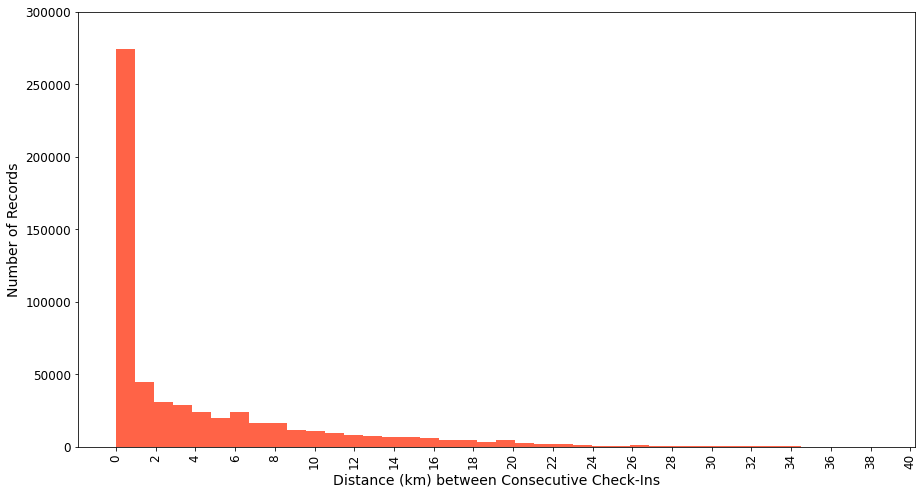

In [31]:
plt.figure(figsize = (15, 8))
plt.hist(cityData.usrLastDist[~pd.isnull(cityData.usrLastDist)], bins = 40, color = 'tomato')
plt.xticks(np.arange(0, 41, 2), rotation = 90, fontsize = 12)
plt.yticks(np.arange(0, 300001, 50000), rotation = 0, fontsize = 12)
plt.xlabel("Distance (km) between Consecutive Check-Ins", fontsize = 14)
plt.ylabel("Number of Records", fontsize = 14)
plt.show()
plt.close()

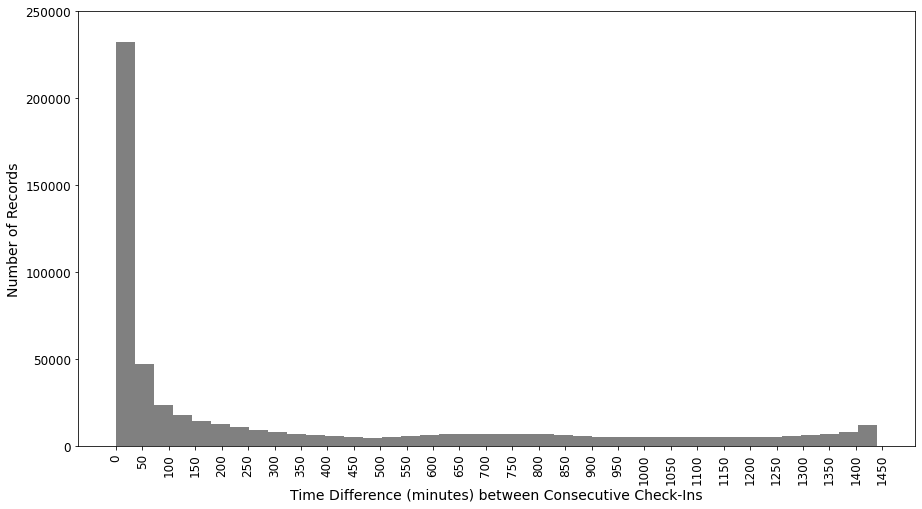

In [32]:
plt.figure(figsize = (15, 8))
plt.hist(cityData.usrLastTimeDiff[~pd.isnull(cityData.usrLastTimeDiff)] / 60, bins = 40, color = 'gray')
plt.xticks(np.arange(0, 1451, 50), rotation = 90, fontsize = 12)
plt.yticks(np.arange(0, 250001, 50000), rotation = 0, fontsize = 12)
plt.xlabel("Time Difference (minutes) between Consecutive Check-Ins", fontsize = 14)
plt.ylabel("Number of Records", fontsize = 14)
plt.show()
plt.close()

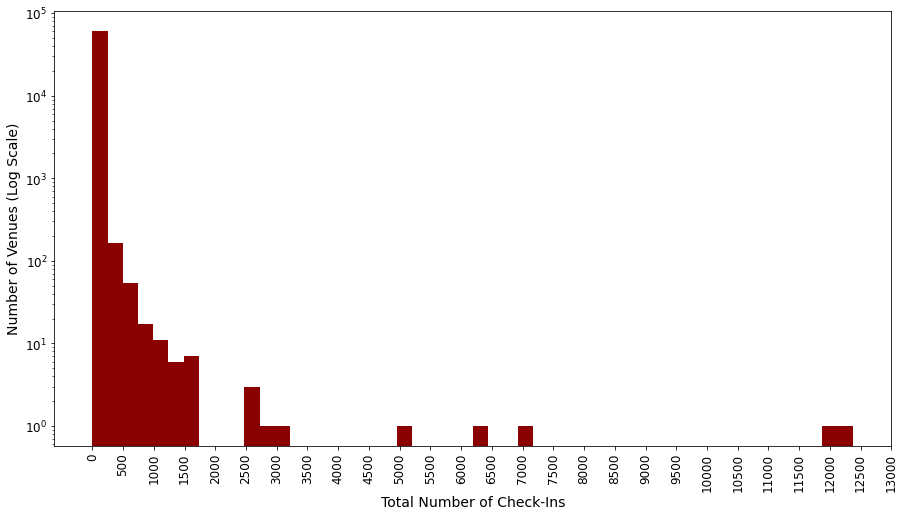

In [33]:
plt.figure(figsize = (15, 8))
plt.hist(list(cityData.groupby(['venueId'])['userId'].count()), color = 'darkred', bins = 50)
plt.gca().set_yscale("log")
plt.xticks(np.arange(0, 13001, 500), rotation = 90, fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Total Number of Check-Ins", fontsize = 14)
plt.ylabel("Number of Venues (Log Scale)", fontsize = 14)
plt.show()
plt.close()

<ipython-input-34-2810237ef446>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  venueCheckIn = cityData.groupby(['venueId', 'userId'])['localTime', 'venueCategory'].count()
<ipython-input-34-2810237ef446>:11: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip')


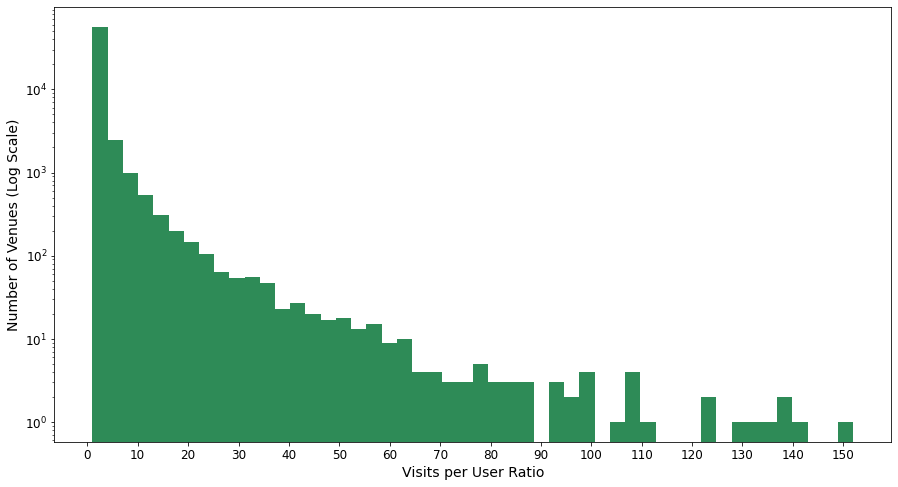

In [34]:
venueCheckIn = cityData.groupby(['venueId', 'userId'])['localTime', 'venueCategory'].count()
venueCheckIn.reset_index(inplace = True)
venueCheckIn = venueCheckIn.loc[:, ['venueId', 'userId', 'localTime']]

# userId = Num of Unique Users, localTime = number of Check-Ins
venueCheckIn = venueCheckIn.groupby(['venueId']).agg({'userId': 'count', 'localTime': 'sum'})

# For each venue, number of check-ins / number of unique customers
plt.figure(figsize = (15, 8))
plt.hist(venueCheckIn.localTime / venueCheckIn.userId, bins = 50, color = 'seagreen')
plt.yscale('log', nonposy='clip')
plt.xticks(np.arange(0, 160, 10), rotation = 0, fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Visits per User Ratio", fontsize = 14)
plt.ylabel("Number of Venues (Log Scale)", fontsize = 14)
plt.show()
plt.close()

<ipython-input-35-bdb4d4aa0fb5>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(0, 0.71, 0.1), fontsize = 12)


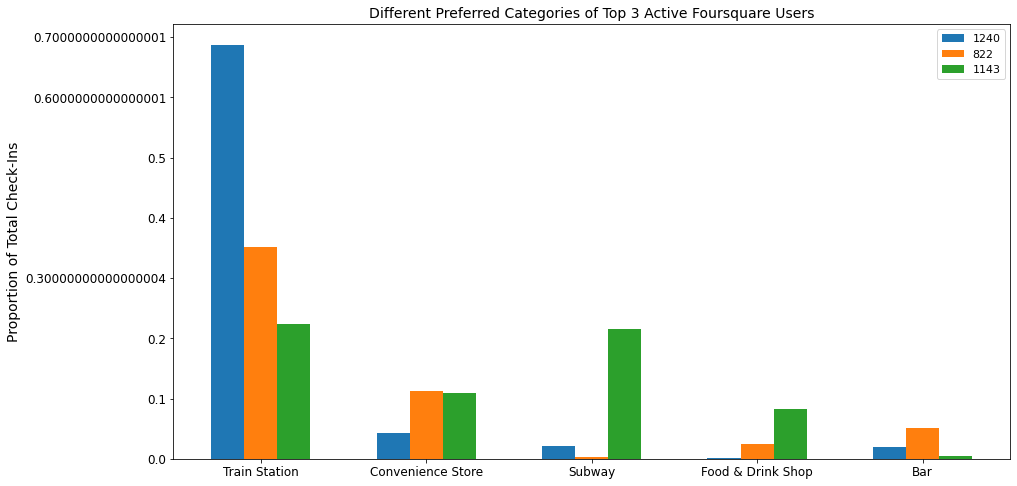

In [35]:
topThreeUsr = cityData.groupby(['userId'])['venueId'].count().sort_values(ascending = False)[:3] # Skip Train Station Category
topEightCat = cityData.groupby(['venueCategory'])['venueId'].count().sort_values(ascending = False)[:8]
topThreeUsr_ByCat = cityData.loc[cityData.userId.isin(topThreeUsr.index.tolist()) & \
                                 cityData.venueCategory.isin(topEightCat.index.tolist()), :] \
                                    .groupby(['userId', 'venueCategory'])['localTime'].count()

topThreeUsr_CatNorm = topThreeUsr_ByCat / topThreeUsr

N_Display = 5

ind = np.arange(N_Display)  # the x locations for the groups
width = 0.2      # the width of the bars

fig = plt.figure(figsize = (15, 8))
ax = fig.add_subplot(111)

xSequence = topThreeUsr_CatNorm.groupby(level = 1).sum().sort_values(ascending = False).index.tolist()
usrSequence = topThreeUsr_CatNorm.iloc[topThreeUsr_CatNorm.index.get_level_values('venueCategory') == 'Train Station'] \
                .sort_values(ascending = False).index.get_level_values(0).tolist()

i = 0
for usr in usrSequence:
    ax.bar(ind + i*width, topThreeUsr_CatNorm[int(usr)][xSequence].values[:N_Display], width, label = str(usr))
    i += 1

ax.set_ylabel('Proportion of Total Check-Ins', fontsize = 14)
ax.set_title('Different Preferred Categories of Top 3 Active Foursquare Users', fontsize = 14)
ax.set_xticks(ind + width)
ax.set_xticklabels(xSequence[:N_Display], fontsize = 12)
ax.set_yticklabels(np.arange(0, 0.71, 0.1), fontsize = 12)

plt.legend(loc = 'upper right', fontsize = 11)

plt.show()
plt.close()

In [36]:
pd.DataFrame(cityData.groupby(['venueId']).agg({'localTime': 'count', 'venueCategory': 'first'}).sort_values(by = 'localTime', 
                                                                                                             ascending = False)).head(150)

,localTime,venueCategory
venueId,,
4b19f917f964a520abe623e3,12372,Train Station
4b0587a6f964a5203d9e22e3,11891,Train Station
4b243a7df964a520356424e3,6969,Train Station
4b093eeff964a520e51423e3,6408,Train Station
4b0587a6f964a5203e9e22e3,5006,Train Station
...,...,...
4b63adf6f964a520a18b2ae3,395,Electronics Store
4b7bb3d8f964a520566b2fe3,395,Train Station
4b767a5af964a520084e2ee3,390,Bar


In [38]:
# Discard venue with less than 100 visits
venueVisit = cityData.groupby('venueId')['localTime'].count()
discardVenue = list(venueVisit[venueVisit <= 100].index)

print("Number of records with venue visited not more than 100 times:", np.sum(venueVisit[venueVisit <= 100]))
print("Number of venues visited not more than 100 times:", len(discardVenue))

cityData_Reduced = cityData.loc[~cityData['venueId'].isin(discardVenue), :]

print("Number of records in reduced dataset: ", cityData_Reduced.shape[0])
print("Number of unique venues in reduced dataset: ", len(set(cityData_Reduced.venueId)))
print("Number of unique venue categories in reduced dataset: ", len(set(cityData_Reduced.venueCategory)))

Number of records with venue visited not more than 100 times: 309032
Number of venues visited not more than 100 times: 61100
Number of records in reduced dataset:  264671
Number of unique venues in reduced dataset:  758
Number of unique venue categories in reduced dataset:  63


In [39]:
# Venue average coordinates - True Geographical Locations of Venues
venueCoord = cityData.groupby(['venueId'])['x', 'y', 'z'].mean()
venueCoord_reduced = venueCoord.loc[venueCoord.index.isin(set(cityData_Reduced.venueId)), :]

venueCoord_reduced

<ipython-input-39-082efcda3df4>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  venueCoord = cityData.groupby(['venueId'])['x', 'y', 'z'].mean()


,x,y,z
venueId,,,
4b0587a1f964a5207f9d22e3,-3950.795425,3339.067051,3719.070816
4b0587a1f964a520989d22e3,-3945.488894,3343.867787,3720.390653
4b0587a1f964a5209b9d22e3,-3949.507611,3340.657183,3719.010651
4b0587a6f964a5203d9e22e3,-3946.352722,3346.717430,3716.910497
4b0587a6f964a5203e9e22e3,-3950.660381,3342.577797,3716.059368
...,...,...,...
4f8d5245e4b0af04c411ee25,-3952.498814,3347.902166,3709.305219
4fa3574a121df8dabaf60d8b,-3950.229783,3341.362597,3717.609670
4fbb6f79e4b04df08f1ded79,-3949.683486,3340.518220,3718.948693


In [40]:
discardVenueDF = cityData.loc[cityData.venueId.isin(discardVenue), :]
discardVenueDF = discardVenueDF.groupby('venueId').first()
discardVenueDF.groupby('venueCategory')['localTime'].count().sort_values(ascending = False)

venueCategory
Japanese Restaurant       5511
Bar                       4002
Ramen /  Noodle House     3599
Convenience Store         3138
CafÃ©                     2182
                          ... 
Castle                       1
Cuban Restaurant             1
Mac & Cheese Joint           1
Gluten-free Restaurant       1
Afghan Restaurant            1
Name: localTime, Length: 247, dtype: int64

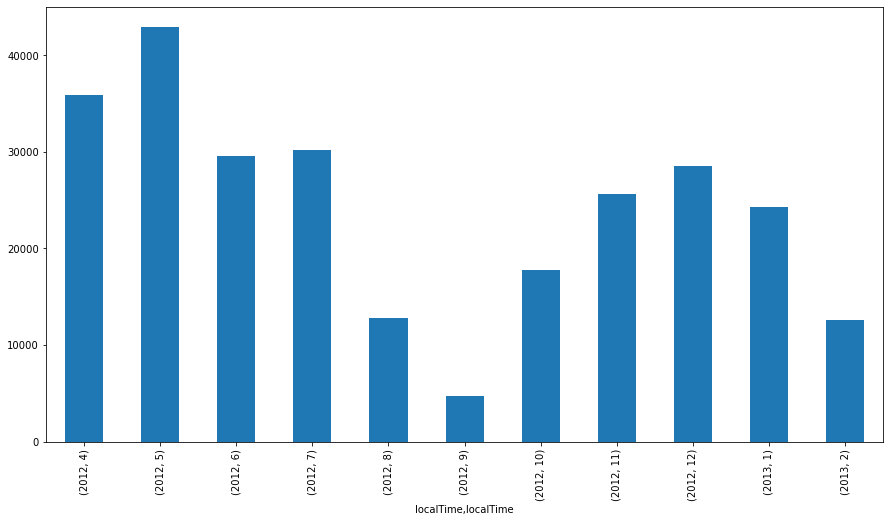

In [41]:
# Histogram by month
plt.figure(figsize = (15, 8))
cityData_Reduced.groupby([cityData_Reduced.localTime.dt.year, cityData_Reduced.localTime.dt.month])['localTime'] \
    .count().plot(kind = "bar")
plt.show()
plt.close()

In [42]:
cutOffIdx = round(cityData_Reduced.shape[0] * 0.8) # Allocate 20% Test Data
trainData = cityData_Reduced.iloc[:cutOffIdx, :]
testData = cityData_Reduced.iloc[cutOffIdx:, :]

In [43]:
print("Earliest timestamp in Training Set: ", min(trainData.localTime))
print("Latest timestamp in Training Set: ", max(trainData.localTime))
print("Number of check-in records in Training Set: ", trainData.shape[0])
print("Number of Unique Users in Training Set: ", len(np.unique(trainData.userId)))
print("Number of Unique Checkin Venues in Training Set: ", len(np.unique(trainData.venueId)))
print("Number of Unique Venue Categories in Training Set: ", len(np.unique(trainData.venueCategory)))
print("Earliest timestamp in Test Set: ", min(testData.localTime))
print("Latest timestamp in Test Set: ", max(testData.localTime))
print("Number of check-in records in Test Set: ", testData.shape[0])
print("Number of Unique Users in Test Set: ", len(np.unique(testData.userId)))
print("Number of Unique Checkin Venues in Test Set: ", len(np.unique(testData.venueId)))
print("Number of Unique Venue Categories in Test Set: ", len(np.unique(testData.venueCategory)))
print("Number of Unique Users in Test Set: ", len(np.unique(testData.userId)))

Earliest timestamp in Training Set:  2012-04-04 04:35:36+00:00
Latest timestamp in Training Set:  2012-12-12 00:28:49+00:00
Number of check-in records in Training Set:  211737
Number of Unique Users in Training Set:  2269
Number of Unique Checkin Venues in Training Set:  758
Number of Unique Venue Categories in Training Set:  63
Earliest timestamp in Test Set:  2012-12-12 00:34:08+00:00
Latest timestamp in Test Set:  2013-02-16 11:34:53+00:00
Number of check-in records in Test Set:  52934
Number of Unique Users in Test Set:  1945
Number of Unique Checkin Venues in Test Set:  754
Number of Unique Venue Categories in Test Set:  61
Number of Unique Users in Test Set:  1945


In [44]:
trainMeanX, trainMeanY, trainMeanZ = np.mean(trainData.loc[:, ['x', 'y', 'z']], axis = 0)
trainMeanTimeDiff = np.nanmean(trainData.usrLastTimeDiff)
trainMostPopularCat = trainData.groupby(['venueCategory'])['venueId'].count().sort_values(ascending = False).index[0]

In [45]:
# Impute
pd.options.mode.chained_assignment = None
trainData.loc[pd.isnull(trainData.usrLastX), 'usrLastX'] = trainMeanX
trainData.loc[pd.isnull(trainData.usrLastY), 'usrLastY'] = trainMeanY
trainData.loc[pd.isnull(trainData.usrLastZ), 'usrLastZ'] = trainMeanZ

testData.loc[pd.isnull(testData.usrLastX), 'usrLastX'] = trainMeanX
testData.loc[pd.isnull(testData.usrLastY), 'usrLastY'] = trainMeanY
testData.loc[pd.isnull(testData.usrLastZ), 'usrLastZ'] = trainMeanZ

trainData.loc[pd.isnull(trainData.usrLastTime), 'usrLastTime'] = trainData.loc[pd.isnull(trainData.usrLastTime), 'localTime'] \
                                                                    - pd.to_timedelta(trainMeanTimeDiff, unit = 's')
trainData.loc[pd.isnull(trainData.usrLastCat), 'usrLastCat'] = trainMostPopularCat

# Impute Last Time Difference
trainLastTimeDiff_Ave = np.nanmean(trainData['usrLastTimeDiff'])
trainData.usrLastTimeDiff.fillna(trainLastTimeDiff_Ave, inplace = True)
testData.usrLastTimeDiff.fillna(trainLastTimeDiff_Ave, inplace = True)

In [46]:
# Count the number of check-ins per user in training set
trainUserCount = trainData.groupby('userId')['venueId'].count()

print("Number of Unique Users in Training Set: ", len(trainUserCount))

# Cold start users = no more than 20 check-ins in training set or new users appearing in testing set
coldStartUsers = set(trainUserCount.index[(trainUserCount <= 10)])
trainUsers = set(trainData.userId)
testUsers = set(testData.userId)
coldStartUsers = coldStartUsers.union(testUsers.difference(trainUsers)) # Union with those users not appearing in train set

print("Number of Cold-Start Users in Test Set: ", len(coldStartUsers))


Number of Unique Users in Training Set:  2269
Number of Cold-Start Users in Test Set:  219


In [53]:
#def predictMultiClassProba(train, test, model, target, predictors, scale = False):
def predictMultiClassProba(train, model, target, predictors, scale = False):
    
    X_train = train.loc[:, predictors].values
    Y_train = train[target].values
        
    #X_test = test.loc[:, predictors].values
    #Y_test = test[target].values
    
    if scale:
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train.astype(float))
        #X_test = scaler.transform(X_test.astype(float))
    
    model = model.fit(X_train, Y_train)
        
    # Print best estimator for cross-validated model
    if hasattr(model, 'best_estimator_'):
        print(model.best_estimator_)
        
    #return model.classes_, model.predict_proba(X_test)
    if scale:
        return model, scaler
    else:
        return model

In [54]:
#def predictNNMultiClassProba(train, test, target, predictors, epochsize, batchsize, lrate, scale = False):
def predictNNMultiClassProba(train, target, predictors, epochsize, batchsize, lrate, scale = False):
    
    X_train = train.loc[:, predictors].values
    Y_train = train[target].values
        
    #X_test = test.loc[:, predictors].values
    #Y_test = test[target].values
    
    if scale:
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train.astype(float))
        #X_test = scaler.transform(X_test.astype(float))
    
    encoder = LabelEncoder()
    Y_trainEnc = encoder.fit_transform(Y_train)
    
    trainLabelsOneHot = to_categorical(Y_trainEnc)
    
    np.random.seed(1)
    
    model = Sequential()
    model.add(Dense(128, input_dim = X_train.shape[1]))
    model.add(Activation('relu'))
    model.add(Dropout(0.55))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.55))
    model.add(Dense(trainLabelsOneHot.shape[1]))
    model.add(Activation('softmax'))
    
    # we'll use categorical xent for the loss, and Adam as the optimizer
    model.compile(loss ='categorical_crossentropy', optimizer = Adam(lr = lrate), metrics = ['accuracy'])
    
    model.fit(X_train, trainLabelsOneHot, epochs = epochsize, batch_size = batchsize, verbose = 2)
    
    #return encoder.classes_, model.predict_proba(X_test, verbose = 0)
    if scale:
        return encoder.classes_, model, scaler
    else:
        return encoder.classes_, model

In [55]:
def calcAccN(trueLabels, predListLabels):
    inTopN = []
    for i in range(len(trueLabels)):
        if trueLabels[i] in predListLabels[i, :]:
            inTopN.append(True)
        else:
            inTopN.append(False)
    
    return np.mean(inTopN)

In [56]:
targetVar_Venue = 'venueId'
targetVar_Cat = 'venueCategory'
predictorVarsTemporal = ['localDayofWeek', 'localHour']

In [57]:
# Decision Tree
Temporal_Xtest_Cold = testData.loc[testData.userId.isin(coldStartUsers), predictorVarsTemporal].values
Venue_Ytest_Cold = testData.loc[testData.userId.isin(coldStartUsers), targetVar_Venue].values

Temporal_Xtest_NonCold = testData.loc[~testData.userId.isin(coldStartUsers), predictorVarsTemporal].values
Venue_Ytest_NonCold = testData.loc[~testData.userId.isin(coldStartUsers), targetVar_Venue].values

starttime = datetime.now()

TemporalTree1 = predictMultiClassProba(trainData, 
                                       GridSearchCV(tree.DecisionTreeClassifier(), 
                                                    param_grid = {"min_samples_leaf": [50, 200, 500]}, 
                                                    cv = TimeSeriesSplit(n_splits = 10)), 
                                       targetVar_Venue, predictorVarsTemporal)

print("Total time to train Decision Tree1: ", datetime.now() - starttime)

starttime = datetime.now()

Proba_TemporalTree1_Cold = TemporalTree1.predict_proba(Temporal_Xtest_Cold)
Proba_TemporalTree1_NonCold = TemporalTree1.predict_proba(Temporal_Xtest_NonCold)

print("Total time to predict using Decision Tree1: ", datetime.now() - starttime)

DecisionTreeClassifier(min_samples_leaf=500)
Total time to train Decision Tree1:  0:00:06.195510
Total time to predict using Decision Tree1:  0:00:00.124666


In [58]:
# Random Forest
starttime = datetime.now()

TemporalRF1 = predictMultiClassProba(trainData, 
                                     GridSearchCV(ensemble.RandomForestClassifier(n_estimators = 10), 
                                                  param_grid = {"min_samples_leaf": [50, 200, 500]}, 
                                                  cv = TimeSeriesSplit(n_splits = 10)), 
                                     targetVar_Venue, predictorVarsTemporal)

print("Total time to train Random Forest1: ", datetime.now() - starttime)

starttime = datetime.now()

Proba_TemporalRF1_Cold = TemporalRF1.predict_proba(Temporal_Xtest_Cold)
Proba_TemporalRF1_NonCold = TemporalRF1.predict_proba(Temporal_Xtest_NonCold)

print("Total time to predict using Random Forest1: ", datetime.now() - starttime)

RandomForestClassifier(min_samples_leaf=500, n_estimators=10)
Total time to train Random Forest1:  0:00:34.507506
Total time to predict using Random Forest1:  0:00:01.912887


In [59]:
# Gaussian Naive Bayes
starttime = datetime.now()

TemporalGNB1 = predictMultiClassProba(trainData, 
                                      naive_bayes.GaussianNB(), 
                                      targetVar_Venue, predictorVarsTemporal)

print("Total time to train Gaussian Naive Bayes1: ", datetime.now() - starttime)

starttime = datetime.now()

Proba_TemporalGNB1_Cold = TemporalGNB1.predict_proba(Temporal_Xtest_Cold)
Proba_TemporalGNB1_NonCold = TemporalGNB1.predict_proba(Temporal_Xtest_NonCold)

print("Total time to predict using Gaussian Naive Bayes1: ", datetime.now() - starttime)


Total time to train Gaussian Naive Bayes1:  0:00:02.986267
Total time to predict using Gaussian Naive Bayes1:  0:00:01.728344


In [60]:
TemporalNN1_Classes, TemporalNN1, TemporalNN1_Scaler = predictNNMultiClassProba(trainData, targetVar_Venue, 
                                                                                predictorVarsTemporal, epochsize = 75, 
                                                                                batchsize = 10000, lrate = 0.005, scale = True)

Proba_TemporalNN1_Cold = TemporalNN1.predict_proba(TemporalNN1_Scaler.transform(Temporal_Xtest_Cold.astype(float)))
Proba_TemporalNN1_NonCold = TemporalNN1.predict_proba(TemporalNN1_Scaler.transform(Temporal_Xtest_NonCold.astype(float)))

Epoch 1/75
22/22 - 2s - loss: 6.2308 - accuracy: 0.0348
Epoch 2/75
22/22 - 2s - loss: 6.0122 - accuracy: 0.0460
Epoch 3/75
22/22 - 2s - loss: 5.9769 - accuracy: 0.0461
Epoch 4/75
22/22 - 2s - loss: 5.9605 - accuracy: 0.0475
Epoch 5/75
22/22 - 2s - loss: 5.9470 - accuracy: 0.0487
Epoch 6/75
22/22 - 2s - loss: 5.9292 - accuracy: 0.0493
Epoch 7/75
22/22 - 2s - loss: 5.9177 - accuracy: 0.0503
Epoch 8/75
22/22 - 2s - loss: 5.9111 - accuracy: 0.0504
Epoch 9/75
22/22 - 2s - loss: 5.9067 - accuracy: 0.0502
Epoch 10/75
22/22 - 2s - loss: 5.9021 - accuracy: 0.0506
Epoch 11/75
22/22 - 2s - loss: 5.8977 - accuracy: 0.0506
Epoch 12/75
22/22 - 2s - loss: 5.8945 - accuracy: 0.0504
Epoch 13/75
22/22 - 2s - loss: 5.8899 - accuracy: 0.0506
Epoch 14/75
22/22 - 2s - loss: 5.8859 - accuracy: 0.0508
Epoch 15/75
22/22 - 2s - loss: 5.8825 - accuracy: 0.0510
Epoch 16/75
22/22 - 2s - loss: 5.8803 - accuracy: 0.0510
Epoch 17/75
22/22 - 2s - loss: 5.8767 - accuracy: 0.0511
Epoch 18/75
22/22 - 2s - loss: 5.8740 - 

In [62]:
test_TrueVenues_Cold = testData.loc[testData.userId.isin(coldStartUsers), targetVar_Venue].values
test_TrueVenues_NonCold = testData.loc[~testData.userId.isin(coldStartUsers), targetVar_Venue].values

for N in [3, 5, 15, 30]:
    
    print("\nN =", N, "\n")

    global_TopN_Venues = np.array([trainData.groupby(targetVar_Venue)['localTime'].count().sort_values(ascending = False).index[:N]])

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Global Popularity Method: ", 
          calcAccN(test_TrueVenues_Cold, np.repeat(global_TopN_Venues, len(test_TrueVenues_Cold), axis = 0)))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Global Popularity Method: ", 
          calcAccN(test_TrueVenues_NonCold, np.repeat(global_TopN_Venues, len(test_TrueVenues_NonCold), axis = 0)))

    Tree_TopN_Venues_Cold = TemporalTree1.classes_[Proba_TemporalTree1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    Tree_TopN_Venues_NonCold = TemporalTree1.classes_[Proba_TemporalTree1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Decision Tree Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_Cold, Tree_TopN_Venues_Cold))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Decision Tree Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_NonCold, Tree_TopN_Venues_NonCold))

    RF_TopN_Venues_Cold = TemporalRF1.classes_[Proba_TemporalRF1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    RF_TopN_Venues_NonCold = TemporalRF1.classes_[Proba_TemporalRF1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Random Forest Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_Cold, RF_TopN_Venues_Cold))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Random Forest Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_NonCold, RF_TopN_Venues_NonCold))

    GNB_TopN_Venues_Cold = TemporalGNB1.classes_[Proba_TemporalGNB1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    GNB_TopN_Venues_NonCold = TemporalGNB1.classes_[Proba_TemporalGNB1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Gaussian NB Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_Cold, GNB_TopN_Venues_Cold))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Gaussian NB Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_NonCold, GNB_TopN_Venues_NonCold))

    NN_TopN_Venues_Cold = TemporalNN1_Classes[Proba_TemporalNN1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    NN_TopN_Venues_NonCold = TemporalNN1_Classes[Proba_TemporalNN1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Neural Network Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_Cold, NN_TopN_Venues_Cold))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Neural Network Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_NonCold, NN_TopN_Venues_NonCold))


N = 3 

Venue Accuracy@3 for Cold-Start Users using Global Popularity Method:  0.09791044776119404
Venue Accuracy@3 for Non-Cold Users using Global Popularity Method:  0.12259310560096763
Venue Accuracy@3 for Cold-Start Users using Decision Tree Estimated Probabilities:  0.09671641791044776
Venue Accuracy@3 for Non-Cold Users using Decision Tree Estimated Probabilities:  0.12231998283228311
Venue Accuracy@3 for Cold-Start Users using Random Forest Estimated Probabilities:  0.09432835820895523
Venue Accuracy@3 for Non-Cold Users using Random Forest Estimated Probabilities:  0.12202735129440684
Venue Accuracy@3 for Cold-Start Users using Gaussian NB Estimated Probabilities:  0.1008955223880597
Venue Accuracy@3 for Non-Cold Users using Gaussian NB Estimated Probabilities:  0.12230047406309136
Venue Accuracy@3 for Cold-Start Users using Neural Network Estimated Probabilities:  0.09074626865671642
Venue Accuracy@3 for Non-Cold Users using Neural Network Estimated Probabilities:  0.12237850

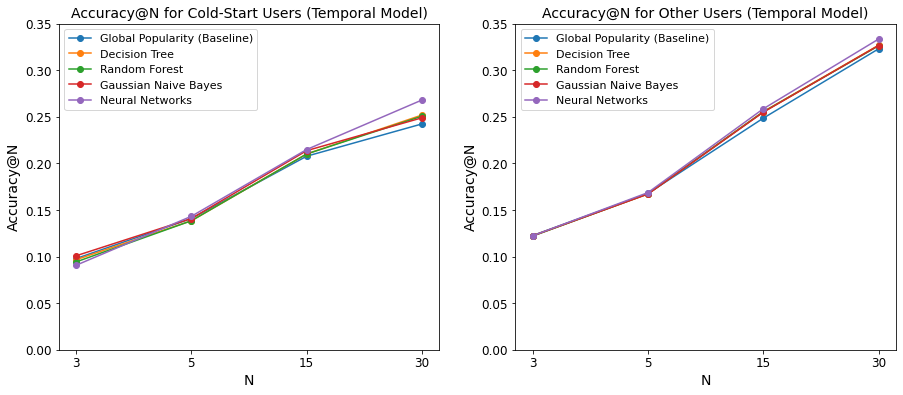

In [63]:
test_TrueVenues_Cold = testData.loc[testData.userId.isin(coldStartUsers), targetVar_Venue].values
test_TrueVenues_NonCold = testData.loc[~testData.userId.isin(coldStartUsers), targetVar_Venue].values

plt.figure(figsize = (15, 6))

globalPopAccN = []
treeAccN = []
rfAccN = []
gnbAccN = []
nnAccN = []

NList = [3, 5, 15, 30]
for N in NList:
    
    global_TopN_Venues = np.array([trainData.groupby(targetVar_Venue)['localTime'].count().sort_values(ascending = False).index[:N]])    
    globalPopAccN.append(calcAccN(test_TrueVenues_Cold, np.repeat(global_TopN_Venues, len(test_TrueVenues_Cold), axis = 0)))
    
    Tree_TopN_Venues_Cold = TemporalTree1.classes_[Proba_TemporalTree1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    treeAccN.append(calcAccN(test_TrueVenues_Cold, Tree_TopN_Venues_Cold))
    
    RF_TopN_Venues_Cold = TemporalRF1.classes_[Proba_TemporalRF1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    rfAccN.append(calcAccN(test_TrueVenues_Cold, RF_TopN_Venues_Cold))
    
    GNB_TopN_Venues_Cold = TemporalGNB1.classes_[Proba_TemporalGNB1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    gnbAccN.append(calcAccN(test_TrueVenues_Cold, GNB_TopN_Venues_Cold))
    
    NN_TopN_Venues_Cold = TemporalNN1_Classes[Proba_TemporalNN1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    nnAccN.append(calcAccN(test_TrueVenues_Cold, NN_TopN_Venues_Cold))
    
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(NList)), globalPopAccN, marker = 'o', label = "Global Popularity (Baseline)")
plt.plot(np.arange(len(NList)), treeAccN, marker = 'o', label = "Decision Tree")
plt.plot(np.arange(len(NList)), rfAccN, marker = 'o', label = "Random Forest")
plt.plot(np.arange(len(NList)), gnbAccN, marker = 'o', label = "Gaussian Naive Bayes")
plt.plot(np.arange(len(NList)), nnAccN, marker = 'o', label = "Neural Networks")

plt.xticks(np.arange(len(NList)), NList, rotation = 0, fontsize = 12)
plt.yticks(np.arange(0, 0.36, 0.05), fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 11)
plt.ylabel('Accuracy@N', fontsize = 14)
plt.xlabel('N', fontsize = 14)
plt.title('Accuracy@N for Cold-Start Users (Temporal Model)', fontsize = 14)

globalPopAccN = []
treeAccN = []
rfAccN = []
gnbAccN = []
nnAccN = []

for N in NList:
    
    global_TopN_Venues = np.array([trainData.groupby(targetVar_Venue)['localTime'].count().sort_values(ascending = False).index[:N]])    
    globalPopAccN.append(calcAccN(test_TrueVenues_NonCold, np.repeat(global_TopN_Venues, len(test_TrueVenues_NonCold), axis = 0)))
    
    Tree_TopN_Venues_NonCold = TemporalTree1.classes_[Proba_TemporalTree1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]
    treeAccN.append(calcAccN(test_TrueVenues_NonCold, Tree_TopN_Venues_NonCold))
    
    RF_TopN_Venues_NonCold = TemporalRF1.classes_[Proba_TemporalRF1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]
    rfAccN.append(calcAccN(test_TrueVenues_NonCold, RF_TopN_Venues_NonCold))
    
    GNB_TopN_Venues_NonCold = TemporalGNB1.classes_[Proba_TemporalGNB1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]
    gnbAccN.append(calcAccN(test_TrueVenues_NonCold, GNB_TopN_Venues_NonCold))
    
    NN_TopN_Venues_NonCold = TemporalNN1_Classes[Proba_TemporalNN1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]
    nnAccN.append(calcAccN(test_TrueVenues_NonCold, NN_TopN_Venues_NonCold))

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(NList)), globalPopAccN, marker = 'o', label = "Global Popularity (Baseline)")
plt.plot(np.arange(len(NList)), treeAccN, marker = 'o', label = "Decision Tree")
plt.plot(np.arange(len(NList)), rfAccN, marker = 'o', label = "Random Forest")
plt.plot(np.arange(len(NList)), gnbAccN, marker = 'o', label = "Gaussian Naive Bayes")
plt.plot(np.arange(len(NList)), nnAccN, marker = 'o', label = "Neural Networks")

plt.xticks(np.arange(len(NList)), NList, rotation = 0, fontsize = 12)
plt.yticks(np.arange(0, 0.36, 0.05), fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 11)
plt.ylabel('Accuracy@N', fontsize = 14)
plt.xlabel('N', fontsize = 14)
plt.title('Accuracy@N for Other Users (Temporal Model)', fontsize = 14)
                         
plt.show()
plt.close()

In [64]:
# Popular Jap Restaurants
popJapRest = trainData \
    .groupby('venueId')['localTime', 'latitude', 'longitude'] \
    .agg({'localTime': 'count', 'latitude': 'mean', 'longitude': 'mean'}) \
    .sort_values(by = 'localTime', ascending = False)
popJapRest = popJapRest.loc[popJapRest.localTime > 250, :]

<ipython-input-64-02957bb2478a>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  popJapRest = trainData \


In [65]:
popJapRest.loc[:, ['longitude', 'latitude']].to_csv('popJapRestaurants_Coordinates.csv', index = False, encoding = 'utf-8')

In [68]:
fig = plt.figure(figsize=(20,10))

plt.title('Map of Tokyo with Popular Japanese Restaurants')

# Create subplot
ax = fig.add_subplot(111)

map1 = Basemap(llcrnrlon = 129.5, llcrnrlat = 30.5, 
               urcrnrlon = 142,urcrnrlat = 42.5, resolution = 'l')

map1.drawcountries()

map1.drawmapboundary(fill_color='#7777ff')
map1.fillcontinents(color='#ddaa66', lake_color='#7777ff', zorder=0)
map1.drawcoastlines()

restLats, restLongs = map1(popJapRest['latitude'].values, popJapRest['longitude'].values)

# adjust size and location of subplot
axins = zoomed_inset_axes(ax, 10, loc = 2)
axins.set_xlim(-20, 0)
axins.set_ylim(3, 18)

plt.xticks(visible=False)
plt.yticks(visible=False)

map2 = Basemap(llcrnrlon = np.min(popJapRest['longitude']) - 0.1, 
               llcrnrlat = np.min(popJapRest['latitude']) - 0.1, 
               urcrnrlon = np.max(popJapRest['longitude']) + 0.1, 
               urcrnrlat = np.max(popJapRest['latitude']) + 0.1, resolution = 'h')

map2.drawmapboundary(fill_color='#7777ff')
map2.fillcontinents(color='#ddaa66', lake_color='#7777ff', zorder=0)
map2.drawcoastlines()
map2.drawcountries()

map2.scatter(restLongs, restLats, color = 'r')

mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5")

#plt.show()
plt.savefig('tokyo.png')
plt.close()

<ipython-input-68-6ab5dc67ca50>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


In [69]:
predictorVars_SpatioLastLoc = ['localDayofWeek', 'localHour', 'usrLastX', 'usrLastY', 'usrLastZ', 'usrLastTimeDiff']

In [71]:
# Decision Tree
SpatioLastLoc_Xtest_Cold = testData.loc[testData.userId.isin(coldStartUsers), predictorVars_SpatioLastLoc].values
Venue_Ytest_Cold = testData.loc[testData.userId.isin(coldStartUsers), targetVar_Venue].values

SpatioLastLoc_Xtest_NonCold = testData.loc[~testData.userId.isin(coldStartUsers), predictorVars_SpatioLastLoc].values
Venue_Ytest_NonCold = testData.loc[~testData.userId.isin(coldStartUsers), targetVar_Venue].values

starttime = datetime.now()

SpatioLastLocTree1 = predictMultiClassProba(trainData, 
                                            GridSearchCV(tree.DecisionTreeClassifier(), 
                                                         param_grid = {"min_samples_leaf": [50, 200, 500]}, 
                                                         cv = TimeSeriesSplit(n_splits = 10)), 
                                            targetVar_Venue, predictorVars_SpatioLastLoc)

print("Total time to train Decision Tree: ", datetime.now() - starttime)

starttime = datetime.now()

Proba_SpatioLastLocTree1_Cold = SpatioLastLocTree1.predict_proba(SpatioLastLoc_Xtest_Cold)
Proba_SpatioLastLocTree1_NonCold = SpatioLastLocTree1.predict_proba(SpatioLastLoc_Xtest_NonCold)

print("Total time to predict using Decision Tree: ", datetime.now() - starttime)

DecisionTreeClassifier(min_samples_leaf=50)
Total time to train Decision Tree:  0:00:54.306668
Total time to predict using Decision Tree:  0:00:00.141658


In [72]:
# Random Forest
starttime = datetime.now()

SpatioLastLocRF1 = predictMultiClassProba(trainData, 
                                          GridSearchCV(ensemble.RandomForestClassifier(n_estimators = 10), 
                                                       param_grid = {"min_samples_leaf": [50, 200, 500]}, 
                                                       cv = TimeSeriesSplit(n_splits = 10)), 
                                          targetVar_Venue, predictorVars_SpatioLastLoc)

print("Total time to train Random Forest: ", datetime.now() - starttime)

starttime = datetime.now()

Proba_SpatioLastLocRF1_Cold = SpatioLastLocRF1.predict_proba(SpatioLastLoc_Xtest_Cold)
Proba_SpatioLastLocRF1_NonCold = SpatioLastLocRF1.predict_proba(SpatioLastLoc_Xtest_NonCold)

print("Total time to predict using Random Forest1: ", datetime.now() - starttime)

RandomForestClassifier(min_samples_leaf=50, n_estimators=10)
Total time to train Random Forest:  0:02:28.104573
Total time to predict using Random Forest1:  0:00:02.074508


In [73]:
# Gaussian Naive Bayes
starttime = datetime.now()

SpatioLastLocGNB1 = predictMultiClassProba(trainData, 
                                           naive_bayes.GaussianNB(), 
                                           targetVar_Venue, predictorVars_SpatioLastLoc)

print("Total time to train Gaussian Naive Bayes: ", datetime.now() - starttime)

starttime = datetime.now()

Proba_SpatioLastLocGNB1_Cold = SpatioLastLocGNB1.predict_proba(SpatioLastLoc_Xtest_Cold)
Proba_SpatioLastLocGNB1_NonCold = SpatioLastLocGNB1.predict_proba(SpatioLastLoc_Xtest_NonCold)

print("Total time to predict using Gaussian Naive Bayes: ", datetime.now() - starttime)

Total time to train Gaussian Naive Bayes:  0:00:02.896896
Total time to predict using Gaussian Naive Bayes:  0:00:02.680833


In [74]:
SpatioLastLocNN1_Classes, SpatioLastLocNN1, SpatioLastLocNN1_Scaler = predictNNMultiClassProba(trainData, targetVar_Venue, 
                                                                                               predictorVars_SpatioLastLoc, 
                                                                                               epochsize = 75, batchsize = 10000, 
                                                                                               lrate = 0.005, scale = True)

Proba_SpatioLastLocNN1_Cold = SpatioLastLocNN1.predict_proba(SpatioLastLocNN1_Scaler.transform(SpatioLastLoc_Xtest_Cold.astype(float)))
Proba_SpatioLastLocNN1_NonCold = SpatioLastLocNN1.predict_proba(SpatioLastLocNN1_Scaler.transform(SpatioLastLoc_Xtest_NonCold.astype(float)))

Epoch 1/75
22/22 - 2s - loss: 6.1957 - accuracy: 0.0395
Epoch 2/75
22/22 - 2s - loss: 5.9161 - accuracy: 0.0534
Epoch 3/75
22/22 - 2s - loss: 5.6522 - accuracy: 0.0640
Epoch 4/75
22/22 - 2s - loss: 5.4911 - accuracy: 0.0704
Epoch 5/75
22/22 - 2s - loss: 5.3983 - accuracy: 0.0753
Epoch 6/75
22/22 - 2s - loss: 5.3400 - accuracy: 0.0771
Epoch 7/75
22/22 - 2s - loss: 5.2944 - accuracy: 0.0794
Epoch 8/75
22/22 - 2s - loss: 5.2561 - accuracy: 0.0812
Epoch 9/75
22/22 - 2s - loss: 5.2265 - accuracy: 0.0825
Epoch 10/75
22/22 - 2s - loss: 5.1990 - accuracy: 0.0845
Epoch 11/75
22/22 - 2s - loss: 5.1741 - accuracy: 0.0855
Epoch 12/75
22/22 - 2s - loss: 5.1546 - accuracy: 0.0877
Epoch 13/75
22/22 - 2s - loss: 5.1321 - accuracy: 0.0892
Epoch 14/75
22/22 - 2s - loss: 5.1129 - accuracy: 0.0913
Epoch 15/75
22/22 - 2s - loss: 5.0917 - accuracy: 0.0918
Epoch 16/75
22/22 - 2s - loss: 5.0770 - accuracy: 0.0930
Epoch 17/75
22/22 - 2s - loss: 5.0603 - accuracy: 0.0931
Epoch 18/75
22/22 - 2s - loss: 5.0442 - 

In [75]:
test_TrueVenues_Cold = testData.loc[testData.userId.isin(coldStartUsers), targetVar_Venue].values
test_TrueVenues_NonCold = testData.loc[~testData.userId.isin(coldStartUsers), targetVar_Venue].values

for N in [3, 5, 15, 30]:
    
    print("\nN =", N, "\n")

    global_TopN_Venues = np.array([trainData.groupby(targetVar_Venue)['localTime'].count().sort_values(ascending = False).index[:N]])

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Global Popularity Method: ", 
          calcAccN(test_TrueVenues_Cold, np.repeat(global_TopN_Venues, len(test_TrueVenues_Cold), axis = 0)))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Global Popularity Method: ", 
          calcAccN(test_TrueVenues_NonCold, np.repeat(global_TopN_Venues, len(test_TrueVenues_NonCold), axis = 0)))

    Tree_TopN_Venues_Cold = SpatioLastLocTree1.classes_[Proba_SpatioLastLocTree1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    Tree_TopN_Venues_NonCold = SpatioLastLocTree1.classes_[Proba_SpatioLastLocTree1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Decision Tree Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_Cold, Tree_TopN_Venues_Cold))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Decision Tree Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_NonCold, Tree_TopN_Venues_NonCold))

    RF_TopN_Venues_Cold = SpatioLastLocRF1.classes_[Proba_SpatioLastLocRF1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    RF_TopN_Venues_NonCold = SpatioLastLocRF1.classes_[Proba_SpatioLastLocRF1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Random Forest Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_Cold, RF_TopN_Venues_Cold))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Random Forest Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_NonCold, RF_TopN_Venues_NonCold))

    GNB_TopN_Venues_Cold = SpatioLastLocGNB1.classes_[Proba_SpatioLastLocGNB1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    GNB_TopN_Venues_NonCold = SpatioLastLocGNB1.classes_[Proba_SpatioLastLocGNB1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Gaussian NB Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_Cold, GNB_TopN_Venues_Cold))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Gaussian NB Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_NonCold, GNB_TopN_Venues_NonCold))

    NN_TopN_Venues_Cold = SpatioLastLocNN1_Classes[Proba_SpatioLastLocNN1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    NN_TopN_Venues_NonCold = SpatioLastLocNN1_Classes[Proba_SpatioLastLocNN1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Neural Network Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_Cold, NN_TopN_Venues_Cold))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Neural Network Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_NonCold, NN_TopN_Venues_NonCold))


N = 3 

Venue Accuracy@3 for Cold-Start Users using Global Popularity Method:  0.09791044776119404
Venue Accuracy@3 for Non-Cold Users using Global Popularity Method:  0.12259310560096763
Venue Accuracy@3 for Cold-Start Users using Decision Tree Estimated Probabilities:  0.25850746268656716
Venue Accuracy@3 for Non-Cold Users using Decision Tree Estimated Probabilities:  0.37866521001190034
Venue Accuracy@3 for Cold-Start Users using Random Forest Estimated Probabilities:  0.25970149253731345
Venue Accuracy@3 for Non-Cold Users using Random Forest Estimated Probabilities:  0.39893482120213036
Venue Accuracy@3 for Cold-Start Users using Gaussian NB Estimated Probabilities:  0.14029850746268657
Venue Accuracy@3 for Non-Cold Users using Gaussian NB Estimated Probabilities:  0.15784545153046295
Venue Accuracy@3 for Cold-Start Users using Neural Network Estimated Probabilities:  0.19223880597014925
Venue Accuracy@3 for Non-Cold Users using Neural Network Estimated Probabilities:  0.2428841

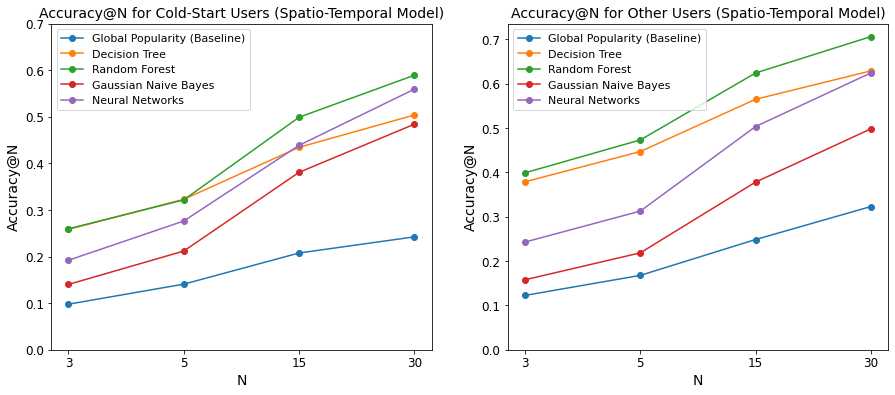

In [76]:
test_TrueVenues_Cold = testData.loc[testData.userId.isin(coldStartUsers), targetVar_Venue].values
test_TrueVenues_NonCold = testData.loc[~testData.userId.isin(coldStartUsers), targetVar_Venue].values

plt.figure(figsize = (15, 6))

globalPopAccN = []
treeAccN = []
rfAccN = []
gnbAccN = []
nnAccN = []

NList = [3, 5, 15, 30]
for N in NList:
    
    global_TopN_Venues = np.array([trainData.groupby(targetVar_Venue)['localTime'].count().sort_values(ascending = False).index[:N]])    
    globalPopAccN.append(calcAccN(test_TrueVenues_Cold, np.repeat(global_TopN_Venues, len(test_TrueVenues_Cold), axis = 0)))
    
    Tree_TopN_Venues_Cold = SpatioLastLocTree1.classes_[Proba_SpatioLastLocTree1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    treeAccN.append(calcAccN(test_TrueVenues_Cold, Tree_TopN_Venues_Cold))
    
    RF_TopN_Venues_Cold = SpatioLastLocRF1.classes_[Proba_SpatioLastLocRF1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    rfAccN.append(calcAccN(test_TrueVenues_Cold, RF_TopN_Venues_Cold))
    
    GNB_TopN_Venues_Cold = SpatioLastLocGNB1.classes_[Proba_SpatioLastLocGNB1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    gnbAccN.append(calcAccN(test_TrueVenues_Cold, GNB_TopN_Venues_Cold))
    
    NN_TopN_Venues_Cold = SpatioLastLocNN1_Classes[Proba_SpatioLastLocNN1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    nnAccN.append(calcAccN(test_TrueVenues_Cold, NN_TopN_Venues_Cold))
    
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(NList)), globalPopAccN, marker = 'o', label = "Global Popularity (Baseline)")
plt.plot(np.arange(len(NList)), treeAccN, marker = 'o', label = "Decision Tree")
plt.plot(np.arange(len(NList)), rfAccN, marker = 'o', label = "Random Forest")
plt.plot(np.arange(len(NList)), gnbAccN, marker = 'o', label = "Gaussian Naive Bayes")
plt.plot(np.arange(len(NList)), nnAccN, marker = 'o', label = "Neural Networks")

plt.xticks(np.arange(len(NList)), NList, rotation = 0, fontsize = 12)
plt.yticks(np.arange(0, 0.71, 0.1), fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 11)
plt.ylabel('Accuracy@N', fontsize = 14)
plt.xlabel('N', fontsize = 14)
plt.title('Accuracy@N for Cold-Start Users (Spatio-Temporal Model)', fontsize = 14)

globalPopAccN = []
treeAccN = []
rfAccN = []
gnbAccN = []
nnAccN = []

for N in NList:
    
    global_TopN_Venues = np.array([trainData.groupby(targetVar_Venue)['localTime'].count().sort_values(ascending = False).index[:N]])    
    globalPopAccN.append(calcAccN(test_TrueVenues_NonCold, np.repeat(global_TopN_Venues, len(test_TrueVenues_NonCold), axis = 0)))
    
    Tree_TopN_Venues_NonCold = SpatioLastLocTree1.classes_[Proba_SpatioLastLocTree1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]
    treeAccN.append(calcAccN(test_TrueVenues_NonCold, Tree_TopN_Venues_NonCold))
    
    RF_TopN_Venues_NonCold = SpatioLastLocRF1.classes_[Proba_SpatioLastLocRF1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]
    rfAccN.append(calcAccN(test_TrueVenues_NonCold, RF_TopN_Venues_NonCold))
    
    GNB_TopN_Venues_NonCold = SpatioLastLocGNB1.classes_[Proba_SpatioLastLocGNB1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]
    gnbAccN.append(calcAccN(test_TrueVenues_NonCold, GNB_TopN_Venues_NonCold))
    
    NN_TopN_Venues_NonCold = SpatioLastLocNN1_Classes[Proba_SpatioLastLocNN1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]
    nnAccN.append(calcAccN(test_TrueVenues_NonCold, NN_TopN_Venues_NonCold))

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(NList)), globalPopAccN, marker = 'o', label = "Global Popularity (Baseline)")
plt.plot(np.arange(len(NList)), treeAccN, marker = 'o', label = "Decision Tree")
plt.plot(np.arange(len(NList)), rfAccN, marker = 'o', label = "Random Forest")
plt.plot(np.arange(len(NList)), gnbAccN, marker = 'o', label = "Gaussian Naive Bayes")
plt.plot(np.arange(len(NList)), nnAccN, marker = 'o', label = "Neural Networks")

plt.xticks(np.arange(len(NList)), NList, rotation = 0, fontsize = 12)
plt.yticks(np.arange(0, 0.71, 0.1), fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 11)
plt.ylabel('Accuracy@N', fontsize = 14)
plt.xlabel('N', fontsize = 14)
plt.title('Accuracy@N for Other Users (Spatio-Temporal Model)', fontsize = 14)
                         
plt.show()
plt.close()

In [77]:
# Construct User-Ven Preference Matrix from Training Set
trainUID = set(trainData.userId)
trainVen = set(trainData.venueId)

usrVenMatrix = []

for uid in trainUID:
    
    currDF = trainData.loc[trainData.userId == uid, ['userId', 'venueId']]
    venMatrixRow = []
    
    for ven in trainVen:
        venMatrixRow.append(np.sum(currDF['venueId'] == ven) + 1) # Laplacian Smoothing: +1
        
    usrVenMatrix.append(venMatrixRow)

usrVenMatrix = np.array(usrVenMatrix)
usrVenMatrix = usrVenMatrix / np.sum(usrVenMatrix, axis = 1)[:, np.newaxis] # Divide by rowsum to get probability
usrVenMatrix = pd.DataFrame(usrVenMatrix, index = trainUID, columns = trainVen)

In [90]:
# Normalise probabilities for Cold-Start User estimations
UID_Xtest_Cold = testData.loc[testData.userId.isin(coldStartUsers), 'userId'].values

# Fill NA with 1 for users not found in usrCatMatrix (assume no specific preference in any category)
Proba_SpatioLastLocTree1_Cold_Norm = Proba_SpatioLastLocTree1_Cold * \
                                        usrVenMatrix.reindex(UID_Xtest_Cold, SpatioLastLocTree1.classes_).fillna(1).values

Proba_SpatioLastLocRF1_Cold_Norm = Proba_SpatioLastLocRF1_Cold * \
                                        usrVenMatrix.reindex(UID_Xtest_Cold, SpatioLastLocRF1.classes_).fillna(1).values

Proba_SpatioLastLocGNB1_Cold_Norm = Proba_SpatioLastLocGNB1_Cold * \
                                        usrVenMatrix.reindex(UID_Xtest_Cold, SpatioLastLocGNB1.classes_).fillna(1).values

Proba_SpatioLastLocNN1_Cold_Norm = Proba_SpatioLastLocNN1_Cold * \
                                        usrVenMatrix.reindex(UID_Xtest_Cold, SpatioLastLocNN1_Classes).fillna(1).values

# Normalise probabilities for Non-Cold User estimations
UID_Xtest_NonCold = testData.loc[~testData.userId.isin(coldStartUsers), 'userId'].values

# Fill NA with 1 for users not found in usrCatMatrix (assume no specific preference in any category)
Proba_SpatioLastLocTree1_NonCold_Norm = Proba_SpatioLastLocTree1_NonCold * \
                                        usrVenMatrix.reindex(UID_Xtest_NonCold, SpatioLastLocTree1.classes_).fillna(1).values

Proba_SpatioLastLocRF1_NonCold_Norm = Proba_SpatioLastLocRF1_NonCold * \
                                        usrVenMatrix.reindex(UID_Xtest_NonCold, SpatioLastLocRF1.classes_).fillna(1).values
    
Proba_SpatioLastLocGNB1_NonCold_Norm = Proba_SpatioLastLocGNB1_NonCold * \
                                        usrVenMatrix.reindex(UID_Xtest_NonCold, SpatioLastLocGNB1.classes_).fillna(1).values
    
Proba_SpatioLastLocNN1_NonCold_Norm = Proba_SpatioLastLocNN1_NonCold * \
                                        usrVenMatrix.reindex(UID_Xtest_NonCold, SpatioLastLocNN1_Classes).fillna(1).values

<ipython-input-90-c77e7a598f4c>:6: FutureWarning: Interpreting call
	'.reindex(a, b)' as 
	'.reindex(index=a, columns=b)'.
Use named arguments to remove any ambiguity. In the future, using positional arguments for 'index' or 'columns' will raise  a 'TypeError'.
  usrVenMatrix.reindex(UID_Xtest_Cold, SpatioLastLocTree1.classes_).fillna(1).values
<ipython-input-90-c77e7a598f4c>:9: FutureWarning: Interpreting call
	'.reindex(a, b)' as 
	'.reindex(index=a, columns=b)'.
Use named arguments to remove any ambiguity. In the future, using positional arguments for 'index' or 'columns' will raise  a 'TypeError'.
  usrVenMatrix.reindex(UID_Xtest_Cold, SpatioLastLocRF1.classes_).fillna(1).values
<ipython-input-90-c77e7a598f4c>:12: FutureWarning: Interpreting call
	'.reindex(a, b)' as 
	'.reindex(index=a, columns=b)'.
Use named arguments to remove any ambiguity. In the future, using positional arguments for 'index' or 'columns' will raise  a 'TypeError'.
  usrVenMatrix.reindex(UID_Xtest_Cold, Spatio

In [91]:
test_TrueVenues_Cold = testData.loc[testData.userId.isin(coldStartUsers), targetVar_Venue].values
test_TrueVenues_NonCold = testData.loc[~testData.userId.isin(coldStartUsers), targetVar_Venue].values

for N in [3, 5, 15, 30]:
    
    print("\nN =", N, "\n")

    global_TopN_Venues = np.array([trainData.groupby(targetVar_Venue)['localTime'].count().sort_values(ascending = False).index[:N]])

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Global Popularity Method: ", 
          calcAccN(test_TrueVenues_Cold, np.repeat(global_TopN_Venues, len(test_TrueVenues_Cold), axis = 0)))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Global Popularity Method: ", 
          calcAccN(test_TrueVenues_NonCold, np.repeat(global_TopN_Venues, len(test_TrueVenues_NonCold), axis = 0)))

    Tree_TopN_Venues_Cold = SpatioLastLocTree1.classes_[Proba_SpatioLastLocTree1_Cold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]
    Tree_TopN_Venues_NonCold = SpatioLastLocTree1.classes_[Proba_SpatioLastLocTree1_NonCold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Decision Tree Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_Cold, Tree_TopN_Venues_Cold))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Decision Tree Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_NonCold, Tree_TopN_Venues_NonCold))

    RF_TopN_Venues_Cold = SpatioLastLocRF1.classes_[Proba_SpatioLastLocRF1_Cold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]
    RF_TopN_Venues_NonCold = SpatioLastLocRF1.classes_[Proba_SpatioLastLocRF1_NonCold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Random Forest Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_Cold, RF_TopN_Venues_Cold))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Random Forest Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_NonCold, RF_TopN_Venues_NonCold))

    GNB_TopN_Venues_Cold = SpatioLastLocGNB1.classes_[Proba_SpatioLastLocGNB1_Cold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]
    GNB_TopN_Venues_NonCold = SpatioLastLocGNB1.classes_[Proba_SpatioLastLocGNB1_NonCold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Gaussian NB Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_Cold, GNB_TopN_Venues_Cold))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Gaussian NB Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_NonCold, GNB_TopN_Venues_NonCold))

    NN_TopN_Venues_Cold = SpatioLastLocNN1_Classes[Proba_SpatioLastLocNN1_Cold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]
    NN_TopN_Venues_NonCold = SpatioLastLocNN1_Classes[Proba_SpatioLastLocNN1_NonCold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Neural Network Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_Cold, NN_TopN_Venues_Cold))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Neural Network Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_NonCold, NN_TopN_Venues_NonCold))


N = 3 

Venue Accuracy@3 for Cold-Start Users using Global Popularity Method:  0.09791044776119404
Venue Accuracy@3 for Non-Cold Users using Global Popularity Method:  0.12259310560096763
Venue Accuracy@3 for Cold-Start Users using Decision Tree Estimated Probabilities:  0.2746268656716418
Venue Accuracy@3 for Non-Cold Users using Decision Tree Estimated Probabilities:  0.49222575547708697
Venue Accuracy@3 for Cold-Start Users using Random Forest Estimated Probabilities:  0.2740298507462687
Venue Accuracy@3 for Non-Cold Users using Random Forest Estimated Probabilities:  0.5191868745000878
Venue Accuracy@3 for Cold-Start Users using Gaussian NB Estimated Probabilities:  0.15880597014925374
Venue Accuracy@3 for Non-Cold Users using Gaussian NB Estimated Probabilities:  0.3932967869057141
Venue Accuracy@3 for Cold-Start Users using Neural Network Estimated Probabilities:  0.21194029850746268
Venue Accuracy@3 for Non-Cold Users using Neural Network Estimated Probabilities:  0.45843656723

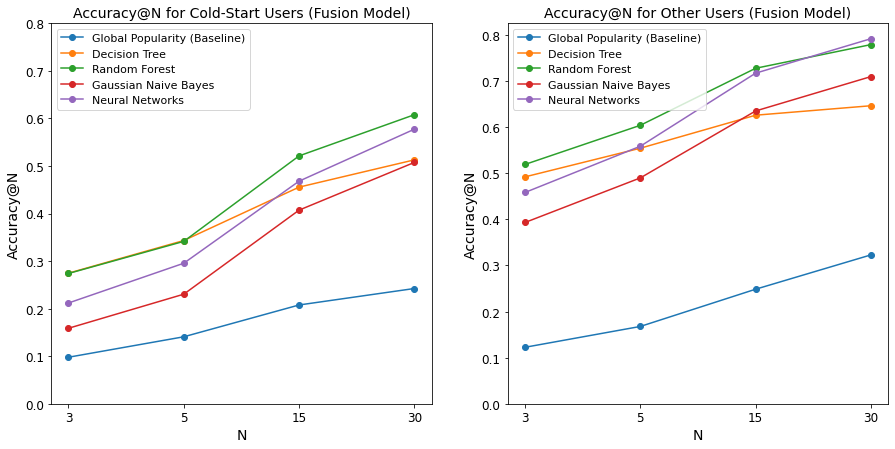

In [92]:
test_TrueVenues_Cold = testData.loc[testData.userId.isin(coldStartUsers), targetVar_Venue].values
test_TrueVenues_NonCold = testData.loc[~testData.userId.isin(coldStartUsers), targetVar_Venue].values

plt.figure(figsize = (15, 7))

globalPopAccN = []
treeAccN = []
rfAccN = []
gnbAccN = []
nnAccN = []

NList = [3, 5, 15, 30]
for N in NList:
    
    global_TopN_Venues = np.array([trainData.groupby(targetVar_Venue)['localTime'].count().sort_values(ascending = False).index[:N]])    
    globalPopAccN.append(calcAccN(test_TrueVenues_Cold, np.repeat(global_TopN_Venues, len(test_TrueVenues_Cold), axis = 0)))
    
    Tree_TopN_Venues_Cold = SpatioLastLocTree1.classes_[Proba_SpatioLastLocTree1_Cold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]
    treeAccN.append(calcAccN(test_TrueVenues_Cold, Tree_TopN_Venues_Cold))
    
    RF_TopN_Venues_Cold = SpatioLastLocRF1.classes_[Proba_SpatioLastLocRF1_Cold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]
    rfAccN.append(calcAccN(test_TrueVenues_Cold, RF_TopN_Venues_Cold))
    
    GNB_TopN_Venues_Cold = SpatioLastLocGNB1.classes_[Proba_SpatioLastLocGNB1_Cold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]
    gnbAccN.append(calcAccN(test_TrueVenues_Cold, GNB_TopN_Venues_Cold))
    
    NN_TopN_Venues_Cold = SpatioLastLocNN1_Classes[Proba_SpatioLastLocNN1_Cold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]
    nnAccN.append(calcAccN(test_TrueVenues_Cold, NN_TopN_Venues_Cold))
    
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(NList)), globalPopAccN, marker = 'o', label = "Global Popularity (Baseline)")
plt.plot(np.arange(len(NList)), treeAccN, marker = 'o', label = "Decision Tree")
plt.plot(np.arange(len(NList)), rfAccN, marker = 'o', label = "Random Forest")
plt.plot(np.arange(len(NList)), gnbAccN, marker = 'o', label = "Gaussian Naive Bayes")
plt.plot(np.arange(len(NList)), nnAccN, marker = 'o', label = "Neural Networks")

plt.xticks(np.arange(len(NList)), NList, rotation = 0, fontsize = 12)
plt.yticks(np.arange(0, 0.81, 0.1), fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 11)
plt.ylabel('Accuracy@N', fontsize = 14)
plt.xlabel('N', fontsize = 14)
plt.title('Accuracy@N for Cold-Start Users (Fusion Model)', fontsize = 14)

globalPopAccN = []
treeAccN = []
rfAccN = []
gnbAccN = []
nnAccN = []

for N in NList:
    
    global_TopN_Venues = np.array([trainData.groupby(targetVar_Venue)['localTime'].count().sort_values(ascending = False).index[:N]])    
    globalPopAccN.append(calcAccN(test_TrueVenues_NonCold, np.repeat(global_TopN_Venues, len(test_TrueVenues_NonCold), axis = 0)))
    
    Tree_TopN_Venues_NonCold = SpatioLastLocTree1.classes_[Proba_SpatioLastLocTree1_NonCold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]
    treeAccN.append(calcAccN(test_TrueVenues_NonCold, Tree_TopN_Venues_NonCold))
    
    RF_TopN_Venues_NonCold = SpatioLastLocRF1.classes_[Proba_SpatioLastLocRF1_NonCold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]
    rfAccN.append(calcAccN(test_TrueVenues_NonCold, RF_TopN_Venues_NonCold))
    
    GNB_TopN_Venues_NonCold = SpatioLastLocGNB1.classes_[Proba_SpatioLastLocGNB1_NonCold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]
    gnbAccN.append(calcAccN(test_TrueVenues_NonCold, GNB_TopN_Venues_NonCold))
    
    NN_TopN_Venues_NonCold = SpatioLastLocNN1_Classes[Proba_SpatioLastLocNN1_NonCold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]
    nnAccN.append(calcAccN(test_TrueVenues_NonCold, NN_TopN_Venues_NonCold))

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(NList)), globalPopAccN, marker = 'o', label = "Global Popularity (Baseline)")
plt.plot(np.arange(len(NList)), treeAccN, marker = 'o', label = "Decision Tree")
plt.plot(np.arange(len(NList)), rfAccN, marker = 'o', label = "Random Forest")
plt.plot(np.arange(len(NList)), gnbAccN, marker = 'o', label = "Gaussian Naive Bayes")
plt.plot(np.arange(len(NList)), nnAccN, marker = 'o', label = "Neural Networks")

plt.xticks(np.arange(len(NList)), NList, rotation = 0, fontsize = 12)
plt.yticks(np.arange(0, 0.81, 0.1), fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 11)
plt.ylabel('Accuracy@N', fontsize = 14)
plt.xlabel('N', fontsize = 14)
plt.title('Accuracy@N for Other Users (Fusion Model)', fontsize = 14)
                         
plt.show()
plt.close()